## MLB Post Season Analysis
By: Brian Preisler
Udacity Data Analysis Nanodegree
November 2016

The questions this analysis will attempt to answer:

- Do the batting averages of American Major League baseball players significantly change either positively or negatively in the post season compared to the regular season?  

- If post season batting averages are significantly different from the regular season, this analysis will look at three potential leading contributors or independent variables to see which, if any, mostly closely affect the dependent variable  
    -Salaries  
    -College experience  
    -Awards earned in regular season

## Load Libraries to be used later

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
from scipy import stats

## Load data from CSVs

In [2]:
#Imports the datasets as pandas dataframes to be used in the analysis
batting = pd.read_csv('C:\\Users\\brian.preisler\\Python\\P2\\baseballdatabank-master\\core\\batting.csv')
batting_post = pd.read_csv('C:\\Users\\brian.preisler\\Python\\P2\\baseballdatabank-master\\core\\battingpost.csv')
salaries = pd.read_csv('C:\\Users\\brian.preisler\\Python\\P2\\baseballdatabank-master\\core\\salaries.csv')
college_playing = pd.read_csv('C:\\Users\\brian.preisler\\Python\\P2\\baseballdatabank-master\\core\\collegeplaying.csv')
awards = pd.read_csv('C:\\Users\\brian.preisler\\Python\\P2\\baseballdatabank-master\\core\\awardsplayers.csv')


### Look at raw data size, length, etc. to ensure future merges are working correctly

In [3]:
#Print out some data to look at columns as well as original size of datasets
print batting.columns
print 'number of rows in batting:', len(batting)
print 'number of rows in batting in the post season:', len(batting_post)
print 'number of rows in batting after grouping on player:',len(batting.groupby('playerID'))
print 'same for post season:', len(batting_post.groupby('playerID'))

Index([u'playerID', u'yearID', u'stint', u'teamID', u'lgID', u'G', u'AB', u'R',
       u'H', u'2B', u'3B', u'HR', u'RBI', u'SB', u'CS', u'BB', u'SO', u'IBB',
       u'HBP', u'SH', u'SF', u'GIDP'],
      dtype='object')
number of rows in batting: 101332
number of rows in batting in the post season: 11690
number of rows in batting after grouping on player: 18659
same for post season: 3973


## Clean data types

In [4]:
#only use stats from the modern era, in alignment with the norm for MLB stat keeping
batting = batting.drop(batting[batting.yearID < 1900].index)
batting_post = batting_post.drop(batting_post[batting_post.yearID < 1900].index)
college_playing = college_playing.drop(college_playing[college_playing.yearID < 1900].index)
salaries = salaries.drop(salaries[salaries.yearID < 1900].index)

#trim down the imported data to just what is needed for clarity
batting_raw = batting.loc[:, ['playerID', 'H', 'AB']]
batting_post_raw = batting_post.loc[:, ['playerID', 'H', 'AB']]
college_playing_raw = college_playing.loc[:, ['playerID', 'yearID']]
awards_raw = awards.loc[:, ['playerID', 'yearID']]

#take a quick look for future reference
batting_post_raw.head(5)

,playerID,H,AB
201,colliji01,9,36
202,crigelo01,6,26
203,dinnebi01,2,11
204,doughpa01,8,34
205,farredu01,0,1



## Arrange data as needed

In [5]:
#grouped by player id and then morphed back into df
#groupby objects aren't as flexible as dfs which is why I change them back
batting_raw_grouped = batting_raw.groupby('playerID', as_index = False)
batting_post_raw_grouped = batting_post_raw.groupby('playerID',as_index = False)
college_playing_raw_grouped = college_playing_raw.groupby('playerID',as_index = False)
salaries_raw_grouped = salaries.groupby('playerID',as_index = False)
awards_raw_grouped = awards.groupby('playerID',as_index = False)

#the variables of the dataframes that will used from now on (trimmed down and grouped appropriately)
batting_df = batting_raw_grouped.aggregate(np.sum)
bp_df = batting_post_raw_grouped.aggregate(np.sum)
cp_df = college_playing_raw_grouped.aggregate(np.sum)
salaries_df = salaries_raw_grouped.aggregate(np.sum)
awards_df = awards_raw_grouped.aggregate(np.sum)

In [6]:
#combine the datasets with an inner join to just keep those players that have stats
#in the regular season and post season, and with a left join to verify if they played
#in college

def combine_dfs(data1, data2):    
    combined = data1.merge(data2, on = 'playerID', how = 'inner')
    return combined

def combine_dfs_left(data1, data2):    
    combined = pd.merge(left = data1, right = data2, how = 'left', left_on = 'playerID', right_on = 'playerID')
    return combined

#combining datasets in order to compare means more easily and verify the same
#number of players
batting_combined = combine_dfs(batting_df, bp_df)

#add an avg column to the dataset for comparison purposes
batting_combined['AVG'] = batting_combined['H_x'] / batting_combined['AB_x']
batting_combined['AVGPOST'] = batting_combined['H_y'] / batting_combined['AB_y']

#create a difference column to see which players performed better or worse in post season
batting_combined['AVG_DIFF'] = batting_combined['AVGPOST'] - batting_combined['AVG']

#using aforementioned function to keep all players in both datasets
batting_combined_college = combine_dfs_left(batting_combined, cp_df)
batting_combined_awards = combine_dfs_left(batting_combined, awards_df)

#print len(batting_combined_college)

#in order to make a binary column later on, replace Nans with a 0
batting_combined_college['yearID'].fillna(0, inplace=True)
batting_combined_awards['yearID'].fillna(0, inplace=True)


batting_combined_college.head(5)

,playerID,H_x,AB_x,H_y,AB_y,AVG,AVGPOST,AVG_DIFF,yearID
0,aaronha01,3771.0,12364.0,25,69,0.304998,0.362319,0.057320,0.0
1,aaronto01,216.0,944.0,0,1,0.228814,0.000000,-0.228814,0.0
2,abadfe01,1.0,8.0,0,0,0.125000,NaN,NaN,0.0
3,abbated01,748.0,2942.0,0,1,0.254249,0.000000,-0.254249,0.0
4,abbotje01,157.0,596.0,0,1,0.263423,0.000000,-0.263423,5977.0


The last function of fillna is one way I dealt with missing values.  I used a left merge which I knew would leave me with missing values for the players who did not go to college.  In order to do later analysis, I filled in those missing values with zeroes.

## Continue to prep data for future correlation analysis

In [7]:
#define function to be used to add binary column
def invert(data):
    if data > 0:
        return 1
    else:
        return 0   
def played_in_college(df):
    over_write = df['yearID'].apply(invert)
    df['yearID'] = over_write
    return df

#use functions to add df column on which to run a correlation
college_dataset = played_in_college(batting_combined_college)
awards_dataset = played_in_college(batting_combined_awards)

#double check to make sure function applied properly
college_dataset.head()

,playerID,H_x,AB_x,H_y,AB_y,AVG,AVGPOST,AVG_DIFF,yearID
0,aaronha01,3771.0,12364.0,25,69,0.304998,0.362319,0.057320,0
1,aaronto01,216.0,944.0,0,1,0.228814,0.000000,-0.228814,0
2,abadfe01,1.0,8.0,0,0,0.125000,NaN,NaN,0
3,abbated01,748.0,2942.0,0,1,0.254249,0.000000,-0.254249,0
4,abbotje01,157.0,596.0,0,1,0.263423,0.000000,-0.263423,1


## Investigating the data

The average of players batting in the regular season is: 0.218
The average of players batting in the post season is: 0.197


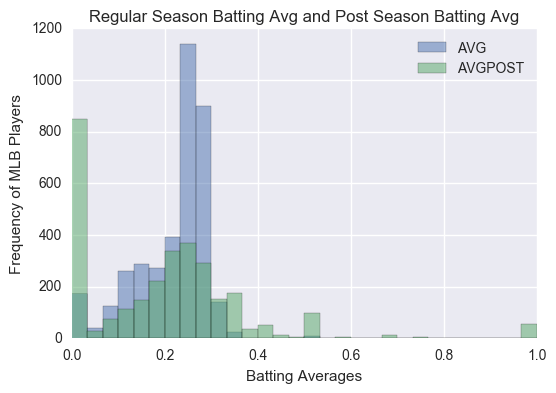

In [8]:
%matplotlib inline

#allow figures to continue opening past warnings
plt.rcParams.update({'figure.max_open_warning': 0})

#finding the means of the two groups 
print 'The average of players batting in the regular season is:', round(batting_combined['AVG'].mean(),3)
print 'The average of players batting in the post season is:', round(batting_combined['AVGPOST'].mean(),3)

#placing the two sets of avg data into one df to be used when plotting and testing
avg_avgpost = batting_combined.loc[:,['AVG', 'AVGPOST']]

#checking out normality of distributions
plot = avg_avgpost.plot.hist(by='AVG', bins=30, alpha = 0.5)
plt.title('Regular Season Batting Avg and Post Season Batting Avg')
plot.set_xlabel('Batting Averages')
plot.set_ylabel('Frequency of MLB Players');

The above graph depicts why the means for regular season and post season batting averages are different.  The spike of batters having an AVG of 0 in the post season is what is being investigated in the following correlations

## Determine Statistical Sig of means difference


In [9]:
#running a paired t-test to determine if diff of means could be due to chance
scipy.stats.ttest_rel(avg_avgpost.loc[:, 'AVG'], avg_avgpost.loc[:, 'AVGPOST'], axis=0, nan_policy='omit')

Ttest_relResult(statistic=12.297664268621062, pvalue=5.9131855996600482e-34)

The scipy library has a built in ability with t-tests to calculate the test by omitting the NaNs.  This allowed me to run the test despite missing values.

A paired t-test was run because the players in each population are the same.  The p-value, or the probability of these means occuring purely by chance is very low meaning that we can say that the averages are statistically significant from each other.  This leads us into the following analysis.

This statistical test was designed to compare the means of the regular season batting avgs of players and the mean of post season batting avgs.  
__  
Ho: mean(regular season avg) = mean(post season avg)  
Ha: mean(regular season avg) != mean(post season avg)  
alpha = .05  
__  

The mean of the regular season avg was .218 and the mean of post season avg was .197 with a pvalue of 5.91e-34. Because the pvalue threshold (alpha level) was chosen at .05, the pvalue of the related ttest ran was inside the lower of the tail which would have been at .025. This means that we reject the null hypothesis that there is no difference between the two.  The two tail test was chosen because I was unsure of whether or not to expect the post season avg to increase or decrease.  A second benefit of the 2 tail is that the alpha level get split in 2 for each tail and thus your result, if greater or smaller than the pvalue, is more rigorous.


## Investigate variables that could explain difference

The correlation between salaries and the incr/dec of batting avg is: -0.008


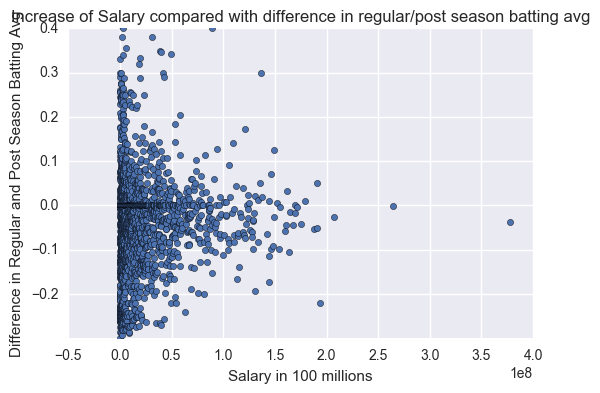

In [33]:
#investigate whether salaries have an impact by checking the correlation with AVG_DIFF
batting_combined_salaries = combine_dfs(batting_combined, salaries_df)
batting_combined_salaries['yearID'].fillna(0, inplace=True)
batting_combined_salaries['AVG_DIFF'].fillna(0, inplace=True)

#print batting_combined_salaries

#check and see if any player variable correlate to their post season performance
avg_diff_salaries = batting_combined_salaries.loc[:,['AVG_DIFF', 'salary']]
avg_diff_salaries = avg_diff_salaries.sort_values(by='salary')
corr_test = avg_diff_salaries.corr()

#plot to look at if increase of salary increases diff in avg
scat = avg_diff_salaries.plot.scatter(x='salary', y='AVG_DIFF')
scat.set_ylim(-.3, .4)
scat.set_title('Increase of Salary compared with difference in regular/post season batting avg')
scat.set_xlabel('Salary in 100 millions')
scat.set_ylabel('Difference in Regular and Post Season Batting Avg')


#print avg_diff_salaries
print 'The correlation between salaries and the incr/dec of batting avg is:', round(corr_test.iloc[1,0],3)

The line chart above is reflective of the very weak correlation of -0.008 that was calculated.  As you can see, there appears to be no relationship either direct or indirect between the salaries or the difference in batting averages.  You would certainly expect to see somewhat of a spike near the 250 million and 400 milion dollar salaries if there was a positive correlation.  

As salaries increase on the x-axis you can see no discernable increase either negatively or positively in regards to the regular/post season batting avg change.  This is backed up by the correlation score so close to 0. 

### Check correlation to college attendance

In [34]:
avg_diff_college = college_dataset.loc[:,['AVG_DIFF', 'yearID']]
corr_test = avg_diff_college.corr()

print 'The correlation between playing college ball and the incr/dec of batting avg is:', round(corr_test.iloc[1,0],3)

The correlation between playing college ball and the incr/dec of batting avg is: 0.029


Another weak correlation leads us to the conclusion that there is no real connection between whether an MLB player played baseball in college before the pros and whether or not he had a higher batting avg in the post season compared to the regular season.

### Check correlation to receiving awards during their career

In [35]:
avg_diff_awards = awards_dataset.loc[:,['AVG_DIFF', 'yearID']]
corr_test = avg_diff_awards.corr()

#print avg_diff_college

print 'The correlation between earning an MLB award in your carreer and the incr/dec of batting avg is:', round(corr_test.iloc[1,0],3)

The correlation between earning an MLB award in your carreer and the incr/dec of batting avg is: 0.038


The third weak correlation also leads us to conclude that there is no connection between the reality that a player earned a league award and whether or not he had a higher batting avg in the post season compared to the regular season.

# Summary

I analyzed the mean batting averages of MLB players from 1900 until 2015 in the regular season in comparison to the post season and found that the difference was statistically significant (a very low p-value was returned).  I further attempted to find a variable that correlated highly with the difference by looking into salaries earned, college experience, or awards won during the regular season.  All of these variables came back with very low correlations leading me to assume that there is no real connection between them and the difference in batting averages.  The real reason may be something more intangible such as a higher level of pressure in the playoffs.  
  
As with any dataset and analysis, there are certainly limitations in the approach I've taken.  By taking a very large timespan (1900-2015) and looking for trends on that data, I may have missed more subtle changes or differences such as the fact that perhaps in the last 25 years there actually is a correlation between salaries and post season batting avg (just a hypothesis).  In addition, I lumped college experience together whether or not they played 1 year or 4 years.  Perhaps actually playing 4 years in college is truly different from playing any less and its effect on batting averages.  These would be great avenues for future analysis on top of what has already been done.

### Sources

For the secondary y axis graph:  
http://stackoverflow.com/questions/15082682/matplotlib-diagrams-with-2-y-axis

For all other code:  
Udacity nanodegree program